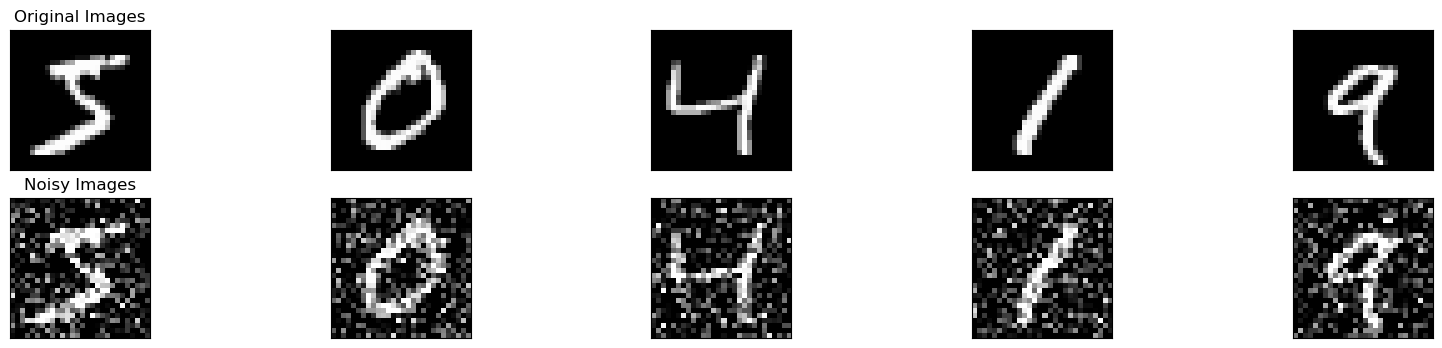

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

noise_factor = 0.35
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, 0., 1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, 0., 1.)

n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        plt.title('Original Images')
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        plt.title('Noisy Images')

plt.show()

# print( x_train.shape)
# print(x_train_noisy.shape)

In [12]:
class ConvAutoencoder(tf.keras.Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(4, kernel_size=3, strides=2, padding='same', activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')
        ])

    def call(self, x):
        x = tf.reshape(x, [-1, 28, 28, 1])
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0682 - val_loss: 0.0087
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0082 - val_loss: 0.0051
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0021 - val_loss: 0.0020
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Threshold: 0.

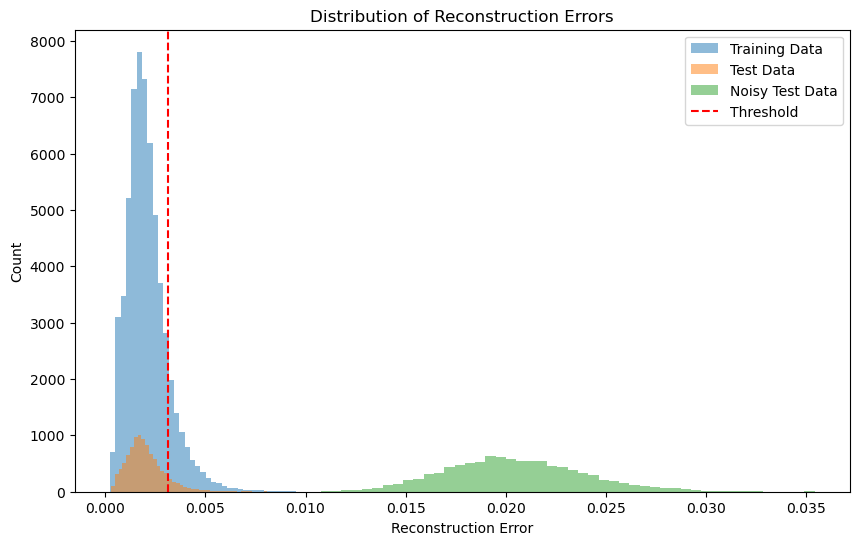

In [13]:
autoencoder = ConvAutoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

x_train = np.array(x_train).reshape(-1, 28, 28, 1)
x_test = np.array(x_test).reshape(-1, 28, 28, 1)
x_test_noisy = np.array(x_test_noisy).reshape(-1, 28, 28, 1)

# history = autoencoder.fit(
history = autoencoder.fit(
    x_train, x_train, 
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, x_test)
)

train_predictions = autoencoder.predict(x_train)
train_reconstruction_errors = np.mean(np.square(x_train - train_predictions), axis=(1,2,3))

threshold = np.mean(train_reconstruction_errors) + np.std(train_reconstruction_errors)

test_predictions = autoencoder.predict(x_test)
test_reconstruction_errors = np.mean(np.square(x_test - test_predictions), axis=(1,2,3))

noisy_test_predictions = autoencoder.predict(x_test_noisy)
noisy_test_reconstruction_errors = np.mean(np.square(x_test - noisy_test_predictions), axis=(1,2,3))

test_classifications = test_reconstruction_errors <= threshold
noisy_test_classifications = noisy_test_reconstruction_errors <= threshold

test_accuracy = np.mean(test_classifications)
noisy_test_accuracy = np.mean(~noisy_test_classifications)  

print(f"Threshold: {threshold:.6f}")
print(f"Original Test Data Accuracy: {test_accuracy:.4f}")
print(f"Noisy Test Data Accuracy: {noisy_test_accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(train_reconstruction_errors, bins=50, alpha=0.5, label='Training Data')
plt.hist(test_reconstruction_errors, bins=50, alpha=0.5, label='Test Data')
plt.hist(noisy_test_reconstruction_errors, bins=50, alpha=0.5, label='Noisy Test Data')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


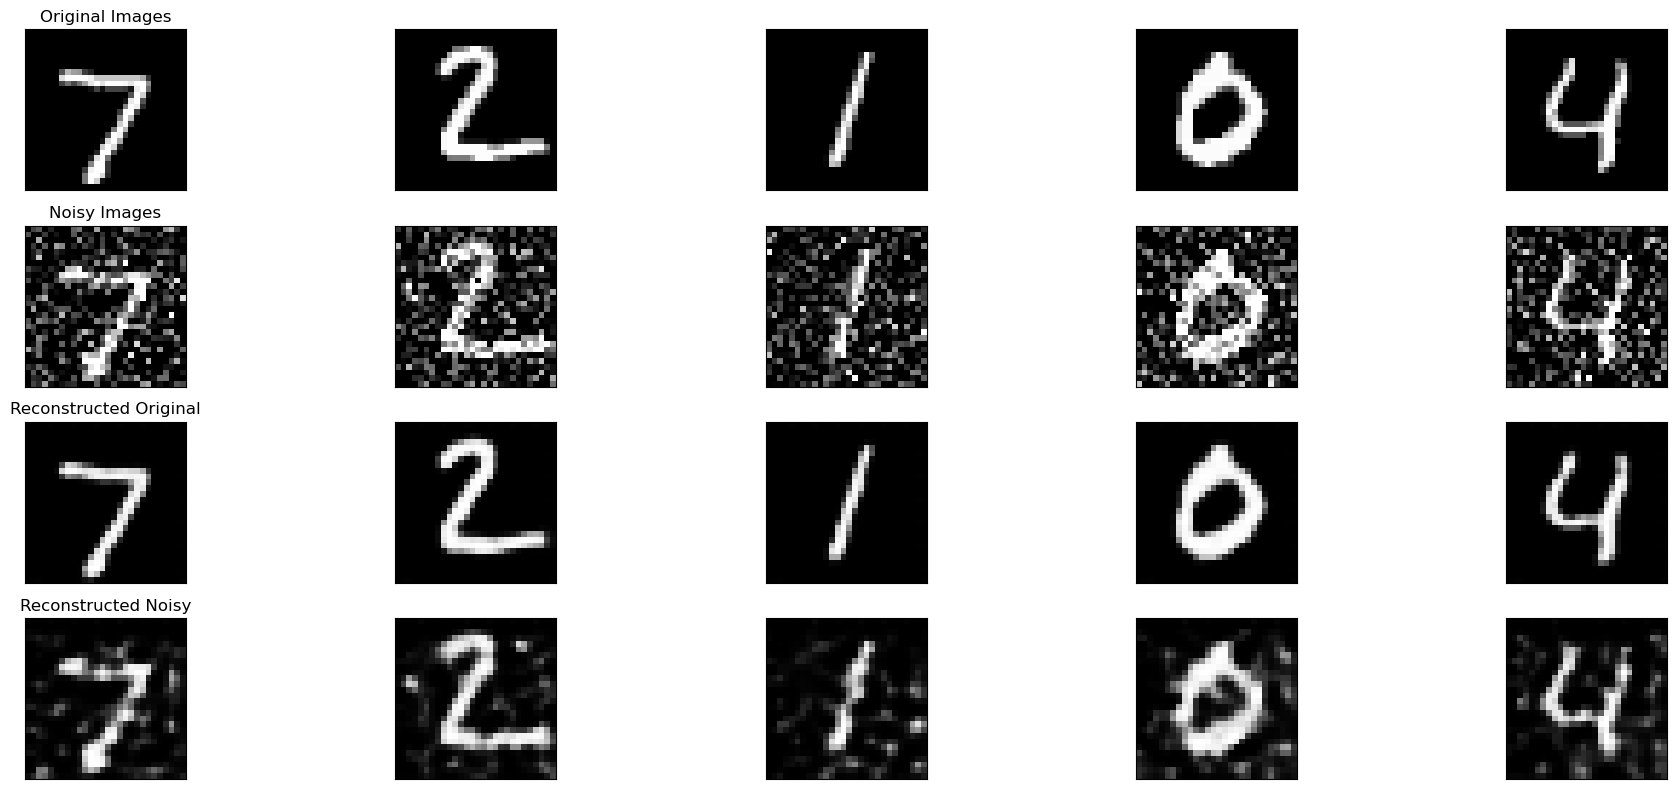

In [14]:
reconstructed_original = autoencoder.predict(x_test)
reconstructed_noisy = autoencoder.predict(x_test_noisy)

n = 5  
plt.figure(figsize=(20, 8))

for i in range(n):
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        plt.title('Original Images')
    
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        plt.title('Noisy Images')
    
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(reconstructed_original[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        plt.title('Reconstructed Original')
    
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(reconstructed_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        plt.title('Reconstructed Noisy')

plt.tight_layout()
plt.show()